In [859]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [860]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

s_math = pd.read_csv('stud_math.csv')

Цель: Отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

# Общие функции

## Границы выбросов для числовых значений

In [861]:
def borders_blowouts(column):
    median = s_math[column].median()
    IQR = s_math[column].quantile(0.75) - s_math[column].quantile(0.25)
    perc25 = s_math[column].quantile(0.25)
    perc75 = s_math[column].quantile(0.75)
    return perc25 - 1.5*IQR, perc75 + 1.5*IQR

## Замена пустых элементов средним

In [862]:
def auto_mean_fix(sp, df):
    for i in sp:
        i_mean = df[i].mean()
        df[i] = df[i].apply(lambda x: i_mean if pd.isna(x) else x)
    return df

## Удаление пустых элементов

In [863]:
def auto_del_fix(sp, df):
    for i in sp:
        df = df.loc[s_math[i].notna()]
    return df

Заведем список для всех колонок, в которых требуется корректировка

In [864]:
sp_mean_auto_fix = []

## Преобразование всех yes/no в 0/1

Автоматически сваливаем все колонки в sp_mean_auto_fix, потому что во всех колонках будут пропуски

In [865]:
def bool_to_num(sp):
    for i in sp:
        s_math[i] = s_math[i].apply(
            lambda x: 1 if x == "yes" else 0 if x == "no" else None)
        sp_mean_auto_fix.append(i)

## Колличественная оценка всех элементов столбца

In [866]:
def items_overview(df, obj=[]):
    for column in df.columns if not obj else obj:
        val = {}
        for i in df[column]:
            if str(i) in val:
                val[str(i)] += 1
            else:
                val[str(i)] = 1
        print(column, "\n", val)

## Проверка на статистическую значимость

In [867]:
def get_stat_dif(df, column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                     df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):
            print(f'Есть статистически значимые различия для {column}')
            break

# Беглый осмотр

Посмотрим, что есть в датасете.

In [868]:
s_math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [869]:
s_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

У нас 13 числовых столбцов и 17 строковых.

Переименуем часть столбцов для удобства использования.

In [870]:
s_math.rename(columns={"Pstatus": "p_status",
                       "Medu": "m_edu",
                       "Fedu": "f_edu",
                       "Mjob": "m_job",
                       "Fjob": "f_job",
                       "studytime, granular": "s_time",
                       },
              inplace=True)

Начнем с числовых

# age

В данном столбце нет пропусков, так что сразу смотрим на распределение.

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

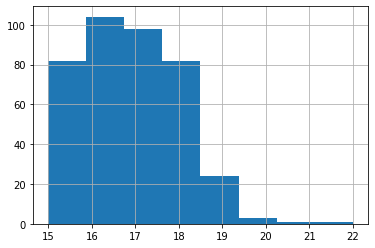

In [871]:
s_math.age.hist(bins=8)
s_math.age.describe()

In [872]:
l, r = borders_blowouts("age")
print(f"границы выбросов [{l}, {r}]")

границы выбросов [13.0, 21.0]


## вывод
Поскольку возраст - это то, на что направленно исследование, считаю нецелесообразным исключать 22. Даже не смотря на то, что он лежит за границей выбросов. 

# m_edu

In [873]:
s_math.m_edu.value_counts(dropna=False)

4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
NaN      3
Name: m_edu, dtype: int64

In [874]:
sp_mean_auto_fix.append("m_edu")

## вывод
Здесь все хорошо 

# f_edu

In [875]:
s_math.f_edu.value_counts(dropna=False)

2.0     106
3.0      96
4.0      88
1.0      78
NaN      24
0.0       2
40.0      1
Name: f_edu, dtype: int64

In [876]:
s_math.loc[s_math.f_edu == 40.0] = 4.0

In [877]:
sp_mean_auto_fix.append("f_edu")

## вывод
Значение 40 было явно ошибочным, на мой взгляд - это опечатка. В процессе обучения модели можно было бы посмотреть, как будет меняться результат при смене значения в данной ячейке на 0 или на среднее по колонке. 

# traveltime

In [878]:
s_math.traveltime.value_counts(dropna=False)

1.0    242
2.0     96
NaN     28
3.0     21
4.0      8
Name: traveltime, dtype: int64

# studytime

In [879]:
s_math.studytime.value_counts(dropna=False)

2.0    194
1.0    103
3.0     63
4.0     28
NaN      7
Name: studytime, dtype: int64

In [880]:
sp_mean_auto_fix.extend(["traveltime", "studytime"])

## вывод
Здесь все хорошо 

# failures

In [881]:
s_math.failures.value_counts(dropna=False)

0.0    292
1.0     49
NaN     22
2.0     16
3.0     15
4.0      1
Name: failures, dtype: int64

In [882]:
s_math.loc[s_math.failures == 4.0] = np.nan

In [883]:
sp_mean_auto_fix.append("failures")

## вывод
4 - явно не валидное значение, сбросили его на None

# s_time

In [884]:
s_math.s_time.value_counts(dropna=False)

-6.0     194
-3.0     103
-9.0      63
-12.0     27
 NaN       8
Name: s_time, dtype: int64

In [885]:
sp_mean_auto_fix.append("s_time")

## вывод
Данного поля нет в описании, но значения выглядят валидными, так что пока оставим.


# famrel

In [886]:
s_math.famrel.value_counts(dropna=False)

 4.0    182
 5.0     98
 3.0     62
 NaN     28
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

In [887]:
s_math.loc[s_math.famrel == -1.0] = np.nan

In [888]:
sp_mean_auto_fix.append("famrel")

## вывод
-1 - явно не валидное значение, сбросили его на None

# freetime

In [889]:
s_math.freetime.value_counts(dropna=False)

3.0    153
4.0    112
2.0     61
5.0     38
1.0     18
NaN     13
Name: freetime, dtype: int64

In [890]:
sp_mean_auto_fix.append("freetime")

# goout

In [891]:
s_math.goout.value_counts(dropna=False)

3.0    127
2.0     99
4.0     84
5.0     52
1.0     23
NaN     10
Name: goout, dtype: int64

In [892]:
sp_mean_auto_fix.append("goout")

# health

In [893]:
s_math.health.value_counts(dropna=False)

5.0    137
3.0     89
4.0     62
1.0     47
2.0     43
NaN     17
Name: health, dtype: int64

In [894]:
sp_mean_auto_fix.extend(["freetime", "goout", "health"])

## вывод
Здесь все хорошо 

# absences

In [895]:
s_math.absences.value_counts(dropna=False)

0.0      111
2.0       60
4.0       52
6.0       31
8.0       21
10.0      17
NaN       14
12.0      12
14.0      11
3.0        8
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
1.0        3
22.0       3
9.0        3
13.0       2
15.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64

count    381.000000
mean       7.270341
std       23.523737
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

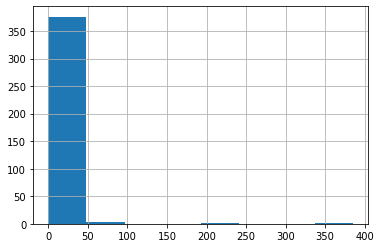

In [896]:
s_math.absences.hist(bins=8)
s_math.absences.describe()

In [897]:
l, r = borders_blowouts("absences")
print(f"границы выбросов [{l}, {r}]")

границы выбросов [-12.0, 20.0]


In [898]:
s_math.absences = s_math.absences.apply(lambda x: None if not l < x < r else x)

In [899]:
sp_mean_auto_fix.append("absences")

## вывод
Поскольку были значения, выходящие за границу выбросов, мы их занулили.

# score

In [900]:
s_math.score.value_counts(dropna=False)

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     30
60.0     30
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
NaN       8
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

count    387.000000
mean      52.273902
std       22.966464
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

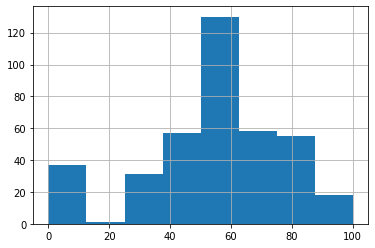

In [901]:
s_math.score.hist(bins=8)
s_math.score.describe()

In [902]:
l, r = borders_blowouts("score")
print(f"границы выбросов [{l}, {r}]")

границы выбросов [-5.0, 115.0]


In [903]:
sp_mean_auto_fix.append("score")

## вывод
Здесь все хорошо 

Теперь рассмотрим столбцы, которые можно привести к числовым.

In [904]:
items_overview(s_math)

school 
 {'GP': 347, 'nan': 2, 'MS': 46}
sex 
 {'F': 206, 'M': 187, 'nan': 2}
age 
 {'18.0': 82, '17.0': 98, '15.0': 81, '16.0': 103, 'nan': 2, '19.0': 24, '22.0': 1, '20.0': 3, '21.0': 1}
address 
 {'U': 293, 'nan': 19, 'R': 83}
famsize 
 {'nan': 29, 'GT3': 259, 'LE3': 107}
p_status 
 {'A': 36, 'nan': 45, 'T': 314}
m_edu 
 {'4.0': 131, '1.0': 59, '3.0': 97, '2.0': 100, 'nan': 5, '0.0': 3}
f_edu 
 {'4.0': 88, '1.0': 78, '2.0': 105, '3.0': 96, 'nan': 26, '0.0': 2}
m_job 
 {'at_home': 58, 'health': 32, 'other': 133, 'services': 96, 'teacher': 55, 'nan': 21}
f_job 
 {'teacher': 29, 'other': 196, 'nan': 38, 'health': 15, 'services': 101, 'at_home': 16}
reason 
 {'course': 137, 'other': 34, 'home': 103, 'reputation': 102, 'nan': 19}
guardian 
 {'mother': 249, 'father': 85, 'nan': 33, 'other': 28}
traveltime 
 {'2.0': 96, '1.0': 241, 'nan': 30, '3.0': 21, '4.0': 7}
studytime 
 {'2.0': 194, '3.0': 63, 'nan': 9, '1.0': 102, '4.0': 27}
failures 
 {'0.0': 292, '3.0': 15, 'nan': 24, '1.0': 49, '2

Преобразовываем все yes/no столбцы в 1/0.

In [905]:
bool_to_num(["schoolsup", "famsup", "paid", "activities",
             "nursery", "higher", "internet", "romantic"])

У нас есть 3 варианта, что делать с None значениями:

1) Ничего

2) Удалить все строки где, есть None

3) Заменить все None значения на средние по столбцу

In [906]:
test_1 = s_math.copy()

In [907]:
test_2 = auto_del_fix(sp_mean_auto_fix, s_math.copy())

In [908]:
test_3 = auto_mean_fix(sp_mean_auto_fix, s_math.copy())

Смотрим на корреляцию цифровых значений

In [909]:
test_1.corr()[lambda x: x >= 0.5]

,age,m_edu,f_edu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,s_time,higher,internet,romantic,famrel,freetime,goout,health,absences,score
age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m_edu,NaN,1.000000,0.629666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_edu,NaN,0.629666,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
traveltime,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
studytime,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
failures,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
schoolsup,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
famsup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
activities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [910]:
test_2.corr()[lambda x: x >= 0.5]

,age,m_edu,f_edu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,s_time,higher,internet,romantic,famrel,freetime,goout,health,absences,score
age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m_edu,NaN,1.000000,0.710118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_edu,NaN,0.710118,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
traveltime,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
studytime,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
failures,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
schoolsup,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
famsup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
activities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [911]:
test_3.corr()[lambda x: x >= 0.5]

,age,m_edu,f_edu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,s_time,higher,internet,romantic,famrel,freetime,goout,health,absences,score
age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m_edu,NaN,1.000000,0.608927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_edu,NaN,0.608927,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
traveltime,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
studytime,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
failures,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
schoolsup,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
famsup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
activities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Вывод
Поскольку ни один из методов не привел к уменьшению числа столбцов, я считаю правильным оставить 3-ий вариант. Так как он самый правильный с моей точки зрения. Повторюсь, в процессе обучения модели можно было бы посмотреть, как будет меняться результат в зависимости от разных датасетов.

Теперь разберемся с нецифровыми значениями и сформируем итоговый датасет

In [912]:
s_math = test_3

In [913]:
items_overview(s_math, obj=["school", "sex", "address", "famsize", "p_status",
                            "m_job", "f_job", "reason", "guardian"])

school 
 {'GP': 347, 'nan': 2, 'MS': 46}
sex 
 {'F': 206, 'M': 187, 'nan': 2}
address 
 {'U': 293, 'nan': 19, 'R': 83}
famsize 
 {'nan': 29, 'GT3': 259, 'LE3': 107}
p_status 
 {'A': 36, 'nan': 45, 'T': 314}
m_job 
 {'at_home': 58, 'health': 32, 'other': 133, 'services': 96, 'teacher': 55, 'nan': 21}
f_job 
 {'teacher': 29, 'other': 196, 'nan': 38, 'health': 15, 'services': 101, 'at_home': 16}
reason 
 {'course': 137, 'other': 34, 'home': 103, 'reputation': 102, 'nan': 19}
guardian 
 {'mother': 249, 'father': 85, 'nan': 33, 'other': 28}


In [914]:
for col in ["school", "sex", "address", "famsize", "p_status",
            "m_job", "f_job", "reason", "guardian"]:
    get_stat_dif(s_math, col)

Есть статистически значимые различия для address
Есть статистически значимые различия для m_job


In [915]:
sp_mean_auto_fix.extend(["age", "address", "m_job"])

In [916]:
s_math = s_math.loc[:, sp_mean_auto_fix]

Удалим строки с отсутствующими значениями из финальной выборки

In [917]:
s_math_model = auto_del_fix(["address", "m_job"], s_math)

In [920]:
s_math_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 0 to 394
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   m_edu       357 non-null    float64
 1   f_edu       357 non-null    float64
 2   traveltime  357 non-null    float64
 3   studytime   357 non-null    float64
 4   failures    357 non-null    float64
 5   s_time      357 non-null    float64
 6   famrel      357 non-null    float64
 7   freetime    357 non-null    float64
 8   goout       357 non-null    float64
 9   freetime    357 non-null    float64
 10  goout       357 non-null    float64
 11  health      357 non-null    float64
 12  absences    357 non-null    float64
 13  score       357 non-null    float64
 14  schoolsup   357 non-null    float64
 15  famsup      357 non-null    float64
 16  paid        357 non-null    float64
 17  activities  357 non-null    float64
 18  nursery     357 non-null    float64
 19  higher      357 non-null    f

# Выводы

1) В данных достаточно много пустых значений, только столбец school, sex и age были заполнены полностью.

2) Выбросы найдены в столбцах f_edu, failures, famrel - по одному в каждом и в absences какое-то количество оказалось за доверительным интервалом. В целом можно сделать вывод о том, что данные достаточно чистые.

3) К сожалению не удалось найти коррелляцию между числовыми значениями и все их пришлось добавить в итоговый датасет.

4) Статистически значимые различия нашлись только для двух номинативных переменных, что не может не радовать.